In [347]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [348]:
def f(x):
    return 3*x**2 - 4*x + 5

In [349]:
f(3)

20

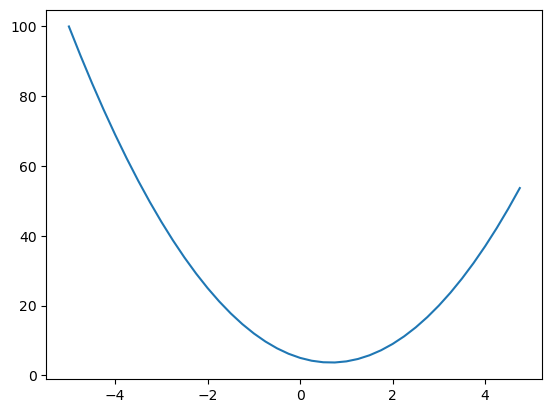

In [350]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [351]:
# https://www.mathsisfun.com/calculus/derivatives-introduction.html
h = 0.001
x = 3.0
(f(x + h) - f(x)) / h

14.00300000000243

In [352]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [353]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [534]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance (other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
            
        out._backward = _backward
        
        return out

    def __radd__(self, other): # other + self
        return self + other

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self, other):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
        
    def __mul__(self, other):
        other = other if isinstance (other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        #return np.tanh(self.data)
        n = self.data
        th = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(th, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - th**2) * out.grad
            
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        return out

    def backward(self):
        topological_sort = []
        visited = set()
        
        def build_topological_order(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topological_order(child)
                topological_sort.append(v)
                
        build_topological_order(self)
        
        self.grad = 1.0
        # now we traverse through the topological order from right to left calling and backward propogate the values
        for i in range(len(topological_sort) - 1, -1, -1):
            topological_sort[i]._backward()

        

In [535]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

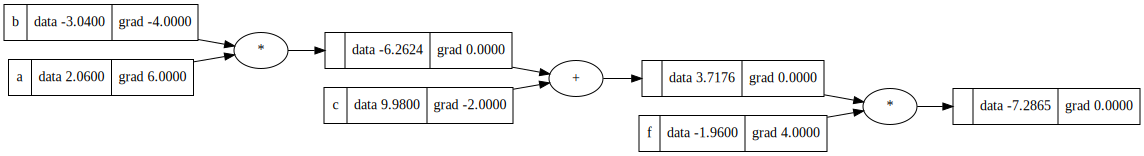

In [536]:
draw_dot(L)

In [537]:
''' dL/dd = f how?
(f(x + h) - f(x)) / h
((d + h) * f) - (d * f)) / h
df + hf - df / h
hf / h = f
'''

''' dL/df = d how?
(f(x + h) - f(x)) / h
(d * (f + h) - (d * f)) / h
df + dh - df / h
dh / h

dd / dc = ?
(f(x + h) - f(x)) / h

dd / de = 1

dL / dc = dd/dc * dL/dd = 1 * -2.0 = -2.0
dL / de = dd/de * dL/dd = 1 * -2.0 = -2.0

e = a * b
(f(x + h) - f(x)) / h
de / da = ((a + h) * b - (a * b)) / h
ab + bh - ab / h
bh / h  = b

dL / da = dc/da * dd/de * dL/dd
dL / da = -3.0 * 1 * -2.0 = 6.0

de / db = a = 2.0
dL / db = dL/dd * dd/de * de/db = -2.0 * 1.0 * 2.0 = -4.0

'''

' dL/df = d how?\n(f(x + h) - f(x)) / h\n(d * (f + h) - (d * f)) / h\ndf + dh - df / h\ndh / h\n\ndd / dc = ?\n(f(x + h) - f(x)) / h\n\ndd / de = 1\n\ndL / dc = dd/dc * dL/dd = 1 * -2.0 = -2.0\ndL / de = dd/de * dL/dd = 1 * -2.0 = -2.0\n\ne = a * b\n(f(x + h) - f(x)) / h\nde / da = ((a + h) * b - (a * b)) / h\nab + bh - ab / h\nbh / h  = b\n\ndL / da = dc/da * dd/de * dL/dd\ndL / da = -3.0 * 1 * -2.0 = 6.0\n\nde / db = a = 2.0\ndL / db = dL/dd * dd/de * de/db = -2.0 * 1.0 * 2.0 = -4.0\n\n'

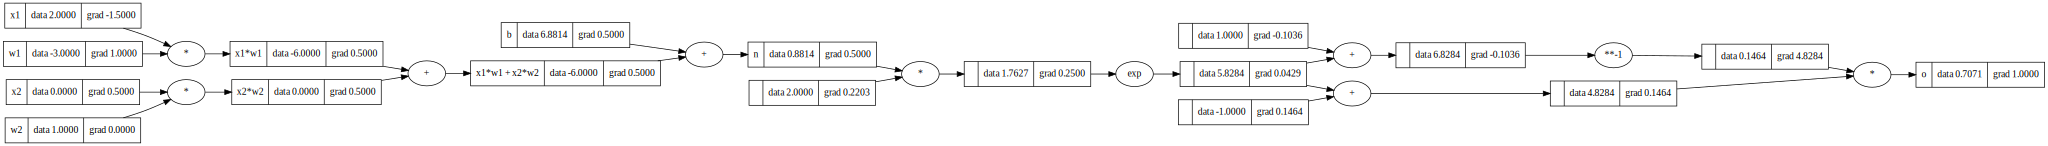

In [538]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [539]:
# o = tanh(n)
# do / dn = 1 - tanh(x)**2
# 1 - o**2
'''n.grad = 1 - o.data**2'''

'n.grad = 1 - o.data**2'

In [540]:
# dn / dx1w1x2w2 = ?
# n = x1w1x2w2 + b
# partial derivative so 1 + 0
# 1
# dn / db = 1
# do / dx1w1x2w2 = do / dn * dn / dx1w1x2w2 = (1 - o.data**2) * (1)
'''x1w1x2w2.grad = 1 - o.data**2 * 1
b.grad = 1 - o.data**2 * 1'''

'x1w1x2w2.grad = 1 - o.data**2 * 1\nb.grad = 1 - o.data**2 * 1'

In [541]:
# we know x1w1x2w2 = x1w1 + x2w2
# dx1w1x2w2 / x1w1 = ?
# 1
# dx1w1x2w2 / x2w2 = 1
'''x1w1.grad = 1 - o.data **2 * 1 * 1
x2w2.grad = 1 - o.data**2 * 1 * 1'''

'x1w1.grad = 1 - o.data **2 * 1 * 1\nx2w2.grad = 1 - o.data**2 * 1 * 1'

In [542]:
# x1w1 = x1 * w1
# dx1w1 / dx1 = w1
# dx1w1 / dw1 = x1
'''w1.grad = (1 - o.data **2) * 1 * 1 * x1.data
x1.grad = (1 - o.data **2) * 1 * 1 * w1.data
w2.grad = (1 - o.data **2) * 1 * 1 * x2.data
x2.grad = (1 - o.data **2) * 1 * 1 * w2.data'''

'w1.grad = (1 - o.data **2) * 1 * 1 * x1.data\nx1.grad = (1 - o.data **2) * 1 * 1 * w1.data\nw2.grad = (1 - o.data **2) * 1 * 1 * x2.data\nx2.grad = (1 - o.data **2) * 1 * 1 * w2.data'

In [543]:
# now we are going to do the same thing using Pytorch
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [544]:
import random

class Neuron:
    # takes number of inputs
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        # in python zip aggregates elements from multiple iterables (like lists, tuples, or strings) into tuples
        # MLP - multi layer perceptron
        act = sum ((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
        
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range (nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
      
    def __call__(self, x):
        for layer in self.layers:
          x = layer(x)
        return x
      
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [545]:
# 3D input
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

value(data=-0.09392334421469854)

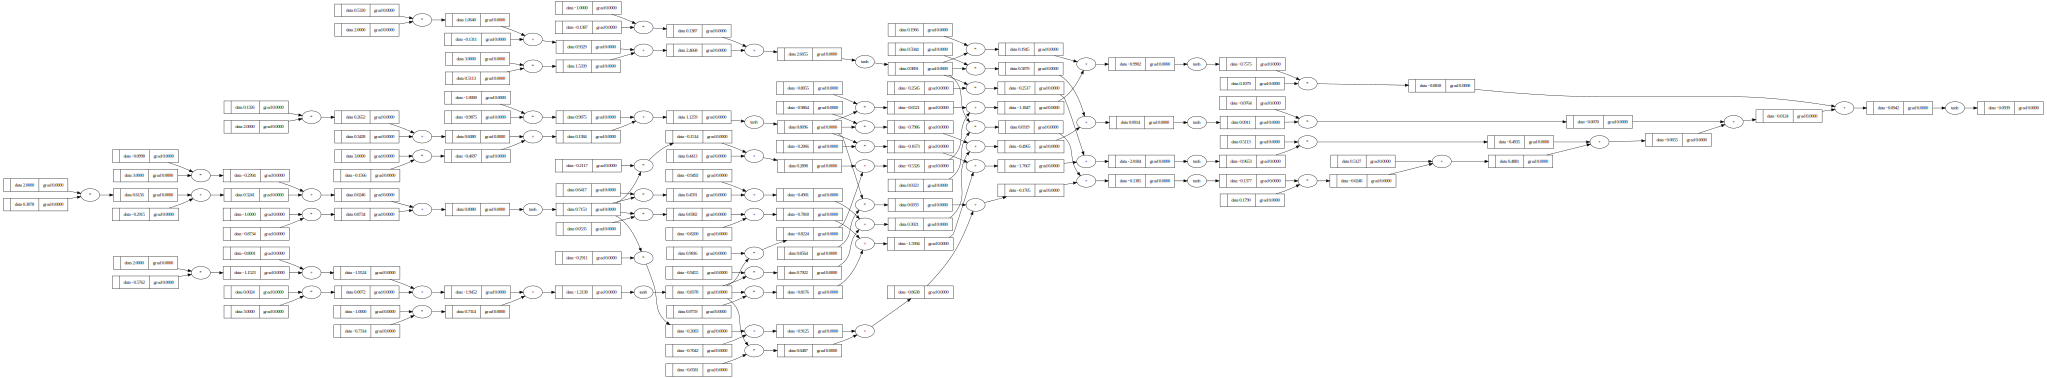

In [546]:
draw_dot(n(x))

In [547]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
y_pred = [n(x) for x in xs]
y_pred

[value(data=-0.09392334421469854),
 value(data=-0.1312901481211811),
 value(data=-0.09623093218690836),
 value(data=-0.027893017256375423)]

In [548]:
# how do we tune the nn to achieve predicted out comes?
# first we calculate loss using mean squared error
loss = sum([(y - y_hat) ** 2 for y_hat, y in zip(ys, y_pred)]) 
loss

value(data=3.8246876726293486)

In [549]:
loss.backward()

In [550]:
n.layers[0].neurons[0].w[0].grad

-0.1658601392327965

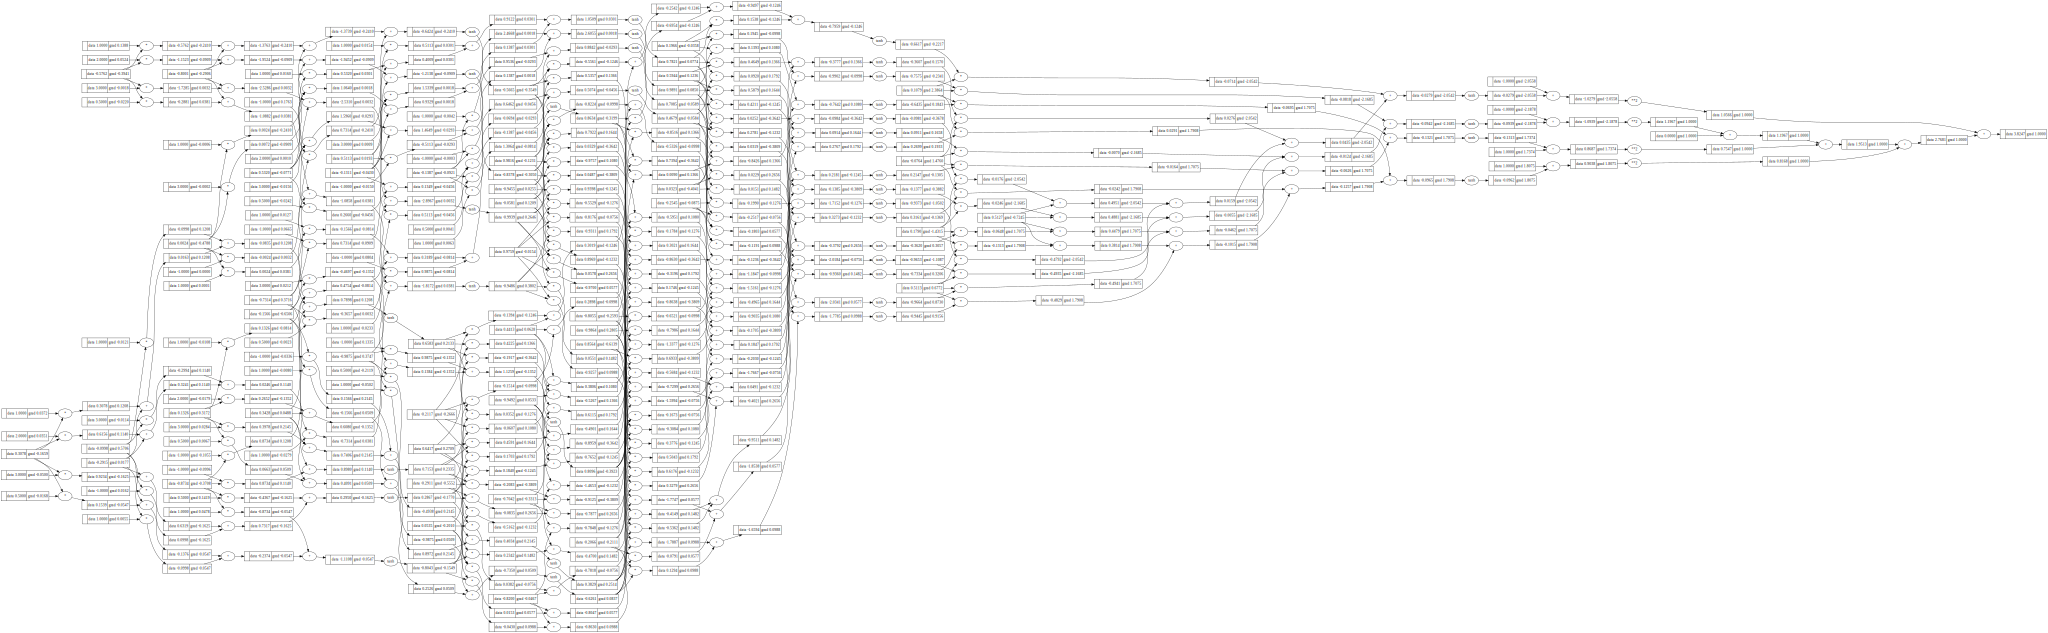

In [551]:
draw_dot(loss)

In [552]:
n.parameters()

[value(data=0.3077838596772584),
 value(data=-0.09981239591963331),
 value(data=-0.8733582846525483),
 value(data=-0.2914807036062832),
 value(data=-0.5761622741344727),
 value(data=0.0023985804119748266),
 value(data=-0.7314433543878744),
 value(data=-0.8000917936042036),
 value(data=0.13260046129466319),
 value(data=-0.15655396155307555),
 value(data=-0.9875456875635931),
 value(data=0.342827104174922),
 value(data=0.5320045953963115),
 value(data=0.51130677813342),
 value(data=-0.1387204693920019),
 value(data=-0.13114907060703684),
 value(data=-0.2911499057909821),
 value(data=-0.058107432863456765),
 value(data=0.856366473080673),
 value(data=0.032278446172248954),
 value(data=-0.704220227062869),
 value(data=0.05345549985212106),
 value(data=0.9759022907356623),
 value(data=-0.20662139118501166),
 value(data=-0.2544752986283063),
 value(data=-0.8200384148159907),
 value(data=0.6417378328584287),
 value(data=-0.9455245092408033),
 value(data=-0.98638310409993),
 value(data=0.59438

In [553]:
n.layers[0].neurons[0].w[0].data

0.3077838596772584

In [560]:
learning_rate = 0.1
for p in n.parameters():
    p.data += -learning_rate * p.grad

In [561]:
n.layers[0].neurons[0].w[0].data

0.33119711695511933

In [562]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -learning_rate * p.grad
  
  print(k, loss.data)

0 1.9679811213871687
1 0.6296547103024713
2 0.22472219850631314
3 0.12346236357559803
4 0.0925929394761304
5 0.07420553426851369
6 0.06180087610021509
7 0.05285033386144776
8 0.04609154408895287
9 0.04081283558692942
10 0.03658045629932408
11 0.0331146184210691
12 0.0302267302263853
13 0.02778507857849914
14 0.025694931083472334
15 0.023886441638804767
16 0.022307006255151304
17 0.02091626931367766
18 0.0196827672883614
19 0.018581616525042706


In [563]:
ypred

[value(data=0.9338667434265527),
 value(data=-0.9405878532093052),
 value(data=-0.9245178397778303),
 value(data=0.9294262853326472)]